<h1>目录</h1>
    
1. [导入所需包](#导入所需包)<br>

2. [基本参数配置](#基本参数配置)<br>
  
  
3. [导入数据集](#导入数据集)<br>

4. [定义生成器与判别器](#定义生成器与判别器)<br>

5. [初始化生成器和判别器](#初始化生成器和判别器)<br>

6. [定义损失函数](#定义损失函数)<br>

7. [开始训练](#开始训练)<br>

8. [绘制损失曲线](#绘制损失曲线)<br>

9. [真假对比](#真假对比)<br>


本项目使用 DCGAN 模型，在自建数据集上进行实验。

本项目使用的数据集是人脸嘴巴区域——微笑表情的数据集

![](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161716081881996551617160816617.jpeg)



数据集文件夹结构如下，图片供 4357 张

```cmd
├─mouth
│  └─smile
     ├─1smile.jpg
     ├─2smile.jpg
     ├─3smile.jpg
     └─....  
```

同时，创建一个 `out` 文件夹来保存训练的中间结果，主要就是看 DCGAN 是如何从一张噪声照片生成我们期待的图片

In [1]:
import os
import time
if os.path.exists("out"):
    print("移除现有 out 文件夹！")
    os.system("rm -r ./out")
time.sleep(1)
print("创建 out 文件夹！")
os.mkdir("./out")

移除现有 out 文件夹！
创建 out 文件夹！


1. 在加载该 NoteBook 文件时,会自动加载数据集至 `./download/mouth` 文件夹下。若没有自动加载数据集，则需要手动加载，手动加载方式如下：

**点击本页面左方 `天池` 按钮（需要在 CPU 环境下），点击 `mouth` 旁边的下载按钮，就会自动加载数据集了！**
![](https://tianchi-public.oss-cn-hangzhou.aliyuncs.com/public/files/forum/161720066070567221617200659786.png)


运行下面代码，对数据集进行解压。

由于图片数量多，解压需要一定时间


In [1]:
!unzip mouth.zip -d ./mouth
print("解压完毕！")

Archive:  mouth.zip
   creating: ./mouth/smile/
  inflating: ./mouth/smile/1000smile.jpg  
  inflating: ./mouth/smile/1001smile.jpg  
  inflating: ./mouth/smile/1002smile.jpg  
  inflating: ./mouth/smile/1003smile.jpg  
  inflating: ./mouth/smile/1004smile.jpg  
  inflating: ./mouth/smile/1005smile.jpg  
  inflating: ./mouth/smile/1006smile.jpg  
  inflating: ./mouth/smile/1008smile.jpg  
  inflating: ./mouth/smile/1009smile.jpg  
  inflating: ./mouth/smile/100smile.jpg  
  inflating: ./mouth/smile/1010smile.jpg  
  inflating: ./mouth/smile/1011smile.jpg  
  inflating: ./mouth/smile/1012smile.jpg  
  inflating: ./mouth/smile/1013smile.jpg  
  inflating: ./mouth/smile/1014smile.jpg  
  inflating: ./mouth/smile/1015smile.jpg  
  inflating: ./mouth/smile/1016smile.jpg  
  inflating: ./mouth/smile/1017smile.jpg  
  inflating: ./mouth/smile/1018smile.jpg  
  inflating: ./mouth/smile/1019smile.jpg  
  inflating: ./mouth/smile/101smile.jpg  
  inflating: ./mouth/smile/1020smile.jpg  
  inflat

# 导入所需包

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 基本参数配置

In [3]:
# 设置一个随机种子，方便进行可重复性实验
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# 数据集所在路径
dataroot = "mouth/"
# 数据加载的进程数
workers = 0
# Batch size 大小
batch_size = 64
# Spatial size of training images. All images will be resized to this
# size using a transformer.
# 图片大小
image_size = 64

# 图片的通道数
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 10
# Learning rate for optimizers
lr = 0.0003
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


Random Seed:  999


# 导入数据集

In [4]:

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

简单看一下我们的原始数据集长啥样

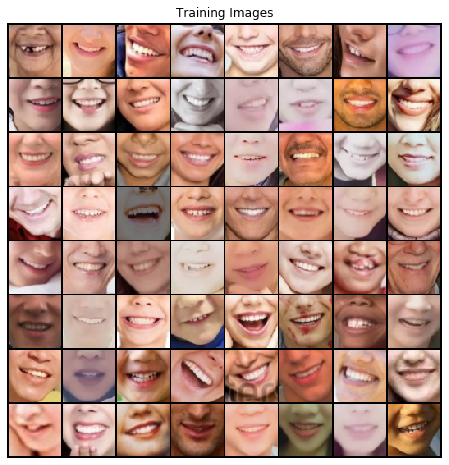

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()

# 定义生成器与判别器

In [6]:
# 权重初始化函数，为生成器和判别器模型初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# 初始化生成器和判别器

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
netG.apply(weights_init)
# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)



Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 定义损失函数

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# 开始训练

In [9]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    import time
    start = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 20 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):

            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            i = vutils.make_grid(fake, padding=2, normalize=True)
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(np.transpose(i, (1, 2, 0)))
            plt.axis('off')  # 关闭坐标轴
            plt.savefig("out/%d_%d.png" % (epoch, iters))
            plt.close(fig)
        iters += 1
    print('time:', time.time() - start)


Starting Training Loop...
[0/10][0/69]	Loss_D: 1.6922	Loss_G: 10.4924	D(x): 0.6837	D(G(z)): 0.6499 / 0.0001
[0/10][50/69]	Loss_D: 0.0341	Loss_G: 35.9770	D(x): 0.9844	D(G(z)): 0.0000 / 0.0000
time: 45.65119695663452
[1/10][0/69]	Loss_D: 0.0003	Loss_G: 33.8338	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[1/10][50/69]	Loss_D: 1.9597	Loss_G: 5.1042	D(x): 0.4813	D(G(z)): 0.0540 / 0.0197
time: 34.60388779640198
[2/10][0/69]	Loss_D: 1.7999	Loss_G: 4.8677	D(x): 0.5162	D(G(z)): 0.1226 / 0.0610
[2/10][50/69]	Loss_D: 1.0036	Loss_G: 6.6382	D(x): 0.4950	D(G(z)): 0.0013 / 0.0036
time: 34.82605242729187
[3/10][0/69]	Loss_D: 0.9899	Loss_G: 0.9510	D(x): 0.5255	D(G(z)): 0.0657 / 0.4808
[3/10][50/69]	Loss_D: 0.8487	Loss_G: 8.4878	D(x): 0.8906	D(G(z)): 0.4741 / 0.0006
time: 34.656062841415405
[4/10][0/69]	Loss_D: 0.6986	Loss_G: 10.3000	D(x): 0.9097	D(G(z)): 0.3872 / 0.0001
[4/10][50/69]	Loss_D: 0.4653	Loss_G: 4.1558	D(x): 0.7023	D(G(z)): 0.0290 / 0.0211
time: 34.64480686187744
[5/10][0/69]	Loss_D: 1.7700	Loss_G

# 绘制损失曲线

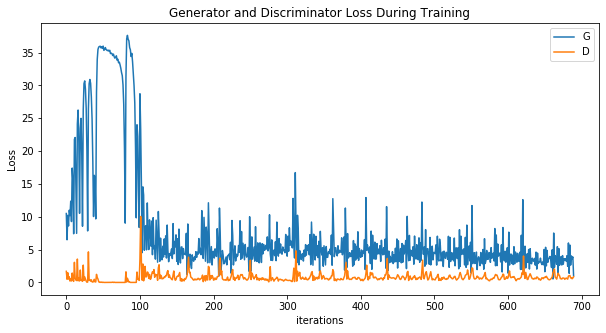

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



# 真假对比

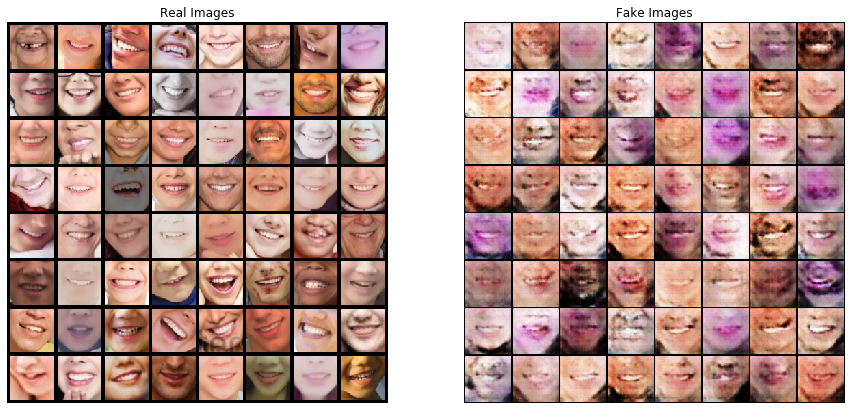

In [14]:
# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
